# Linear Regression Assignment 

## Introduction
For this assignment, we are going to explore data from activity trackers. Activity trackers are applications that track your activity using your smartphone, a smartwatch, wrist band or a clip-on device. Popular applications include Steps (iPhone), Apple Watch, Fitbit and Jawbone. For a study in France, over 900 volunteers received a Fitbit Zip (a clip-on activity tracker) and recorded their daily steps, distance and calories. 

In [23]:
import seaborn as sns #this is the plotting library I'll be using 
import pandas as pd #"as pd" means that we can use the abbreviation in commands
import matplotlib.pyplot as plt #we need Matplotlib for setting the labels in the Seaborn graphs


## Read & Merge files
We will merge the csv files on the 'id'-row, since both datasets use it. 
Also, by using `sep=None`, pandas will automatically recognize the seperator. 


In [24]:
df1= pd.read_csv('survey.csv', encoding='UTF-8')
df2 = pd.read_csv('steps.csv', encoding='UTF-8', sep=None, engine='python')

df = pd.merge(df1, df2, on = 'id')


df['weight'].value_counts() #Get all the values. This may be less useful when there are many values.

72.0     40
65.0     35
73.0     32
80.0     31
55.0     31
         ..
128.0     1
116.0     1
102.0     1
101.0     1
105.0     1
Name: weight, Length: 72, dtype: int64

## Data Cleaning

We will remove unlikely values, ex. `weight > 200kg`  or  `weight < 30kg` if these are true, the entire row will be set to NaN.

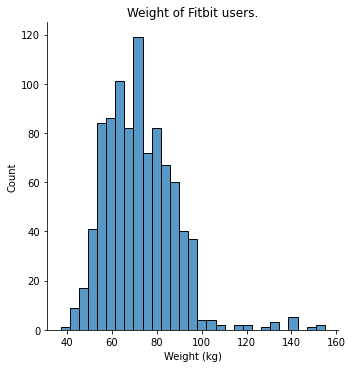

In [25]:
df['weight'] = df['weight'].apply(pd.to_numeric, errors='coerce')

def above_200(weight):
    if(weight > 200.0): 
        return float('NaN')
    else: 
        return weight
    
def below_30(weight):
    if(weight < 30.0):
        return float('NaN')
    else: 
        return weight
    
df['weight'] = df['weight'].apply(above_200)
df['weight'] = df['weight'].apply(below_30)


sns.displot(df['weight'].dropna(), kde=False) #Selecting the rating column. I need to drop the NA's for the plot
plt.title('Weight of Fitbit users.')
plt.xlabel('Weight (kg)')
plt.ylabel('Count')
plt.show()

## Feature Engineering

In [26]:
print(df.head())
def average_age(age):
    if age == '<25':
        return 20
    elif age == '25-34':
        return 30
    elif age == '35-44':
        return 40
    elif age == '45-54':
        return 50
    elif age == '55-64':
        return 60
    elif age == '65-74':
        return 70
    elif age == '75-84':
        return 80

df['age'] = df['age'].apply(average_age)
print(df.head())

   id         city  gender    age  hh_size  education          education_1  \
0   1     Bordeaux    Male  25-34        4          4  Master or doctorate   
1   2        Lille    Male  35-44        1          3             Bachelor   
2   3  Montpellier    Male  25-34        2          2  Master or doctorate   
3   4         Lyon    Male    <25        1          1             Bachelor   
4   5  Montpellier  Female  25-34        3          4             Bachelor   

   height  weight  20-6-2013  ...  4-5-2014  5-5-2014  6-5-2014  7-5-2014  \
0   178.0    98.0        NaN  ...       NaN       NaN       NaN       NaN   
1   180.0    77.0        NaN  ...       NaN       NaN       NaN       NaN   
2   180.0    83.0        NaN  ...    3914.0    4364.0       NaN       NaN   
3   178.0    80.0        NaN  ...       NaN       NaN       NaN       NaN   
4   167.0    61.0        NaN  ...       NaN       NaN       NaN       NaN   

   8-5-2014  9-5-2014  10-5-2014  11-5-2014  12-5-2014  13-5-2014  
